# Project and classify a new query study onto an integrated reference atlas (no sharing)

- In this notebook we will demnsotrate how you can build a reference atlas and then project 
a new query study on the top of your reference atlas

- We provide a cell type classifier if you have cell type labels for the reference data to transfer labels from
reference to query study

In [1]:
import os
os.chdir("../")

In [2]:
import scarches as sca
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

`condition_key` is the column name which stores batch ids in your `adata.obs`

In [3]:
condition_key = "study"

### Loading data

This dataset is already preprocessd and has only 1000 HVGs. We always recommend to use highly variable genes for training.

In [4]:
adata = sc.read("./tests/data/pancreas_normalized_hvg.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

#### We hold out one of our studies to be used as query study later 

In [5]:
target_conditions = ["Pancreas CelSeq2"]

reference_adata

In [6]:
reference_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
reference_adata

View of AnnData object with n_obs × n_vars = 13255 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [7]:
query_adata = adata[adata.obs[condition_key].isin(target_conditions)]
query_adata

View of AnnData object with n_obs × n_vars = 2426 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

The `list` of unique batch labels are latter passed to the model `conditions` parameters to let the model know that these
are different batches af data.

In [8]:
reference_batch_labels = reference_adata.obs[condition_key].unique().tolist()

In [9]:
reference_batch_labels

['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas SS2']

note that our `adata.X` contrains log-normalized gene expression while
`adata.raw.X.` contains raw count values

In [10]:
adata.X.max()

15.727888

In [11]:
adata.raw.X.max()

874247.0

#### Create an instance of scArches model for reference integration

There are some parameters that worth to be mentioned here:

1. __task_name__: name of the task (i.e dataset) which you are going to train scArches on it.
2. __x_dimension__: number of dimensions in expression space
3. __z_dimension__: number of dimensions in latent space of scArches
4. __n_conditions__: list of unique conditions in your data (batches, datasets, or domains) (see above to get and idea)
5. __gene_names__: list of gene names used as scArches' input
6. __model_path__: path to save trained scArches model and its configuration files.
7. __alpha__: KL divergence coefficient for VAE. Biger alpha (1<=alpha<=0.1)  -> better mixing , small alpha (alpha <= 0.001): good mixing while having disctinct cell types
9. __loss_fn__: loss function to be used in scArches. Can be one of `mse`, `sse`, `nb`, or `zinb`. Please __NOTE__ that If you are going to use `nb` or `zinb` loss function, we suggest that setting `beta` hyperparameter to zero will be the best config for scArches to train on your task. 
10. __seed__: random seed


__Note__ : `nb` (negative binomial) and `zinb` (zero inflated `nb`) require raw count data in your `adata.raw.X` and normalaized log-transformed values in `adata.X`. The data must also contain `adata.obs["size_factors"]`which are the normalization factor used
to normalze each cell count values. We suggest to use `scarches.data.normalize_hvg()` ([see here](https://scarches.readthedocs.io/en/latest/api/data.html)) function or use scanpy's `scanpy.pp.normalize_total(adata,...,key_added="size_factors")`([see here](https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.normalize_total.html#scanpy.pp.normalize_total)). Note that you have to specify `key_added="size_factors` in scanpy's `normalize_total` to store these values in `adata.obs["normalize_total"]`. Either of these functions will add these values to to your `adata` and make it ready to train count models.

__HINT__ : we recommend to use `nb` loss, however if you did not find the results satisfying then consider using `sse`

In [12]:
network = sca.models.scArches(task_name='pancreas_reference',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 20],
                              gene_names=adata.var_names.tolist(),
                              conditions=reference_batch_labels,
                              use_batchnorm=False,
                              alpha=0.0001,
                              eta=50,
                              beta=20,
                              loss_fn='mse',
                              device='cpu',
                              model_path="./models/scArches/",
                              seed = 20
                              )

Start running on cpu...
scArches's network has been successfully constructed!
scArches's network has been successfully compiled!


#### Train scArches

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __condition_key__: name of the column in `adata.obs` which contains the batch_id for each sample.
3. __n_epochs__: number of iterations used to train scArches.
4. __batch_size__: number of sample used to sample as mini-batches in order to optimize scArches.
8. __save__: whether to save scArches' model and configs after training phase or not. 
9. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [13]:
network.train(reference_adata,
              n_epochs=150,
              condition_key=condition_key,
              batch_size=512,
              retrain=False)

scArches's network has been successfully compiled!
cvae's weights has been successfully restored!


### Get latent output for the reference dataset

Latent space representation of reference data can be computed using `get_latent` function
This function has the following parameters:

1. __adata__: Annotated dataset to be transformed to latent space
2. __batch_key__: Name of the column in `obs` matrix in `adata` which contains the study for each sample.


In [14]:
latent_adata = network.get_latent(reference_adata,condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 13255 × 20
    obs: 'batch', 'study', 'cell_type', 'size_factors'

### UMAP visualization of reference latent with Scanpy

In [18]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

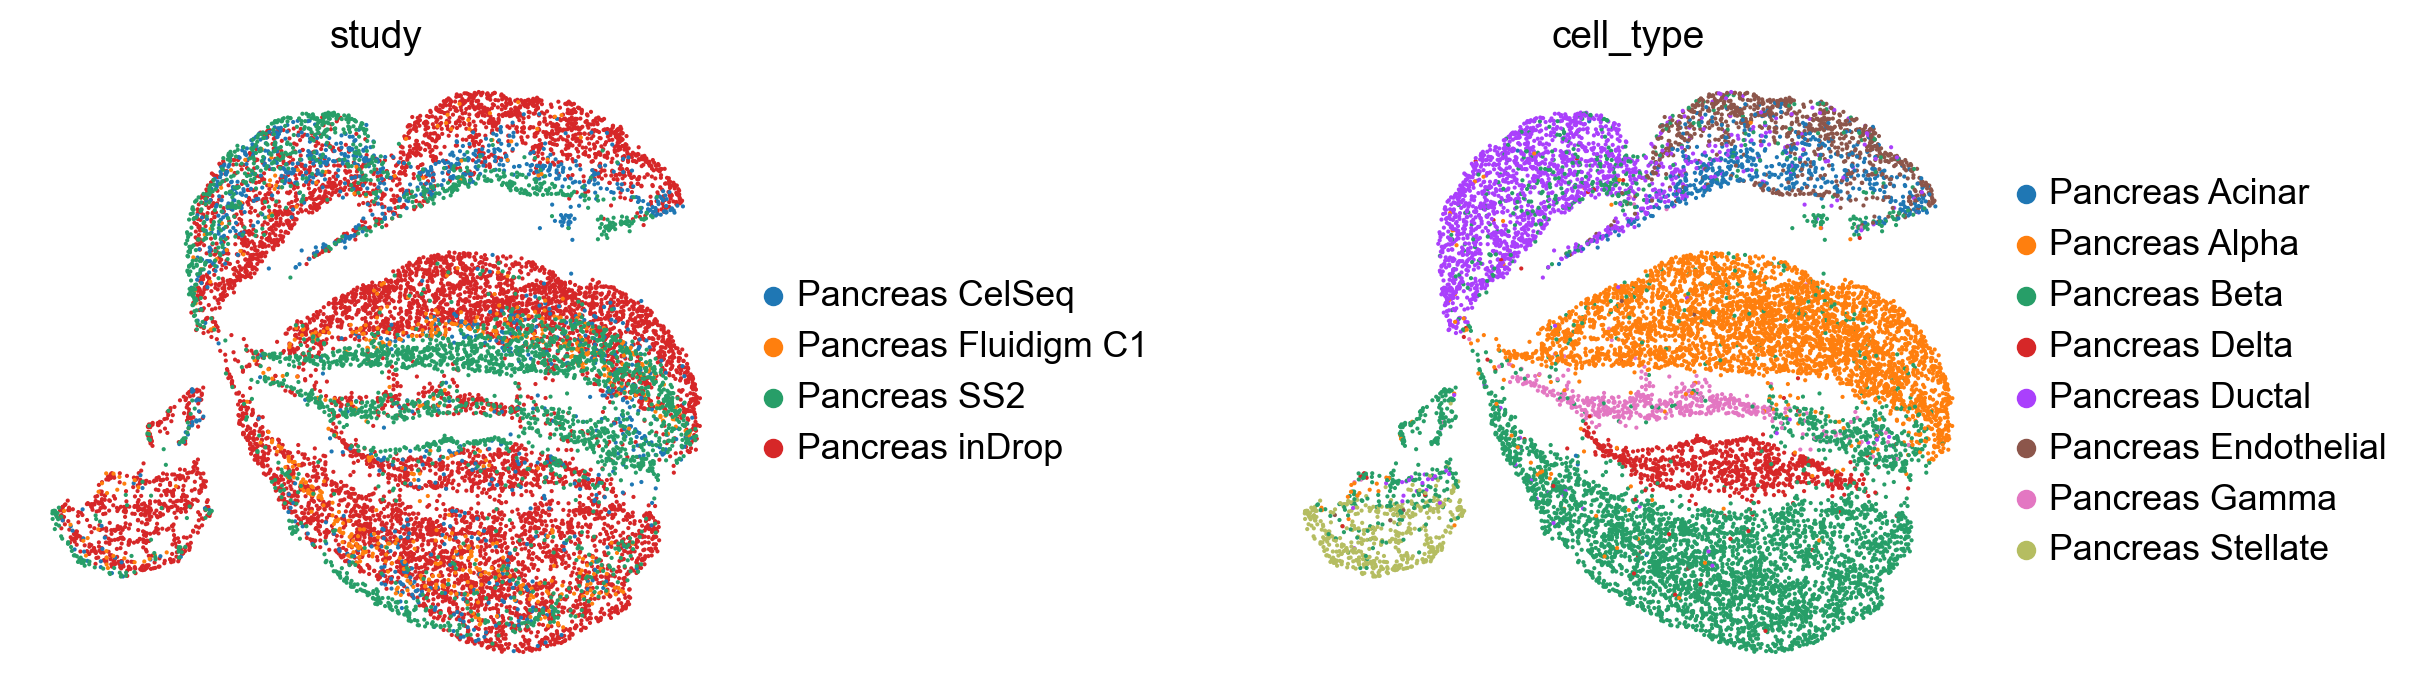

In [19]:
sc.pl.umap(latent_adata, color=[condition_key, "cell_type"], 
           frameon=False, wspace=0.6)

### Projecting query data on the top of reference data 
In order to perform Architecture surgery on pre-trained scArches model, `operate` function is available with the following arguments:

1. __network__: pre-trained scArches object.
2. __new_task_name__: name of the task you want to solve (related to query atlas you have)
3. __new_conditions__: list of (unique) new studies.

In [14]:
new_network = sca.operate(network,
                          new_task_name="pancreas_query",
                          new_conditions=target_conditions)

Start running on cpu...
scArches's network has been successfully constructed!
scArches's network has been successfully compiled!
scArches's network has been successfully compiled!


### Train with query dataset

In [15]:
new_network.train(query_adata,
                  condition_key=condition_key,
                  batch_size=128,
                  n_epochs=100)

 |████████████████████| 100.0%  - loss: 113.6538 - kl_loss: 1172.4009 - mmd_loss: 0.0000 - mse_loss: 113.5366 - val_loss: 107.5789 - val_kl_loss: 1052.8469 - val_mmd_loss: 0.0000 - val_mse_loss: 107.4737

scArches has been successfully saved in ./models/scArches/pancreas_query.


### Project query+reference data in to the latent space

In [16]:
latent_adata = new_network.get_latent(adata, condition_key)

- Note that `latent_adata` contains integrated latent representation for both query and reference data, this adata can be used
for down-stream analysis such as clustering, explatory analysis, differential test and etc

In [17]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

##### as you can see `Pancrease Celseq2 ` is added to the reference data

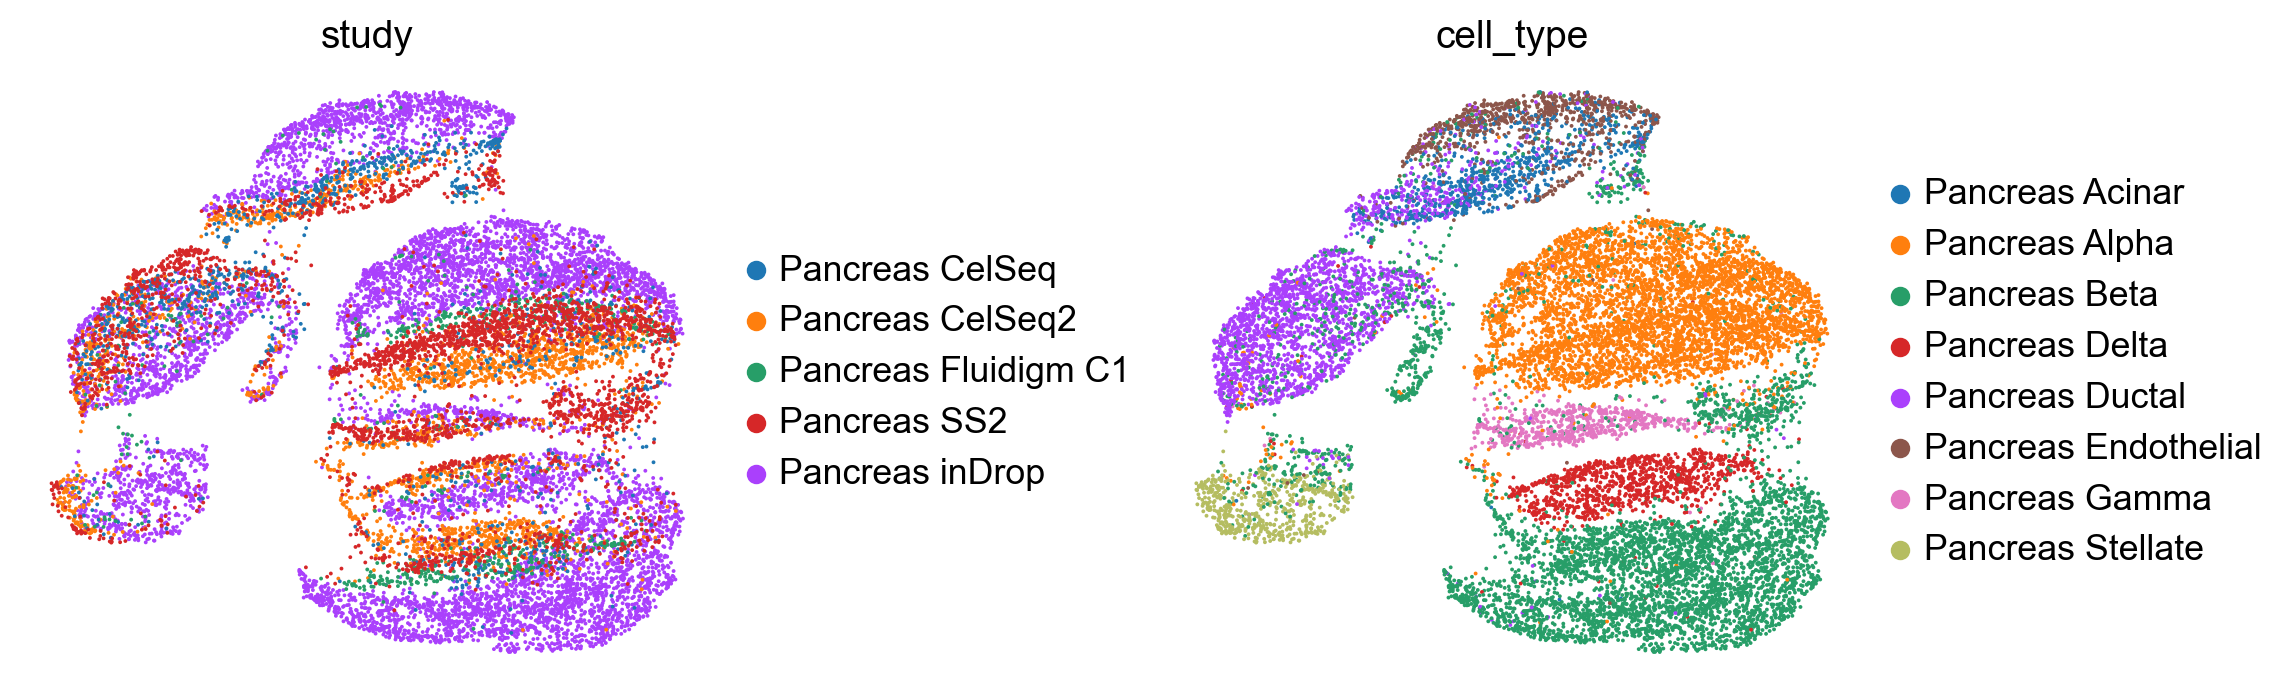

In [18]:
sc.pl.umap(latent_adata, color=[condition_key, "cell_type"], 
           wspace=0.5, frameon=False)

### Transferring  cell type labels from reference to query data

In order to annotate cell types in the query data (`query_adata`), you can use `scArches.ann.weighted_knn` function. There are a few arguments explained below.

1. __n_neighbors__: Number of nearest neighbors used to train the weighted KNN classifier.
2. __threshold__: uncertainty threshold to be used to label cells with high uncertainty as 'Unknown'. cells with `uncertainty` > `threshold` will be labeled as unknown.
3. __label_key__: column containing cell-type labels in `adata.obs`.

In [19]:
n_neighbors = 5
threhsold = 0.5

### Project query and reference data in the latent space

In [20]:
train_latent = new_network.get_latent(reference_adata, condition_key)
valid_latent = new_network.get_latent(query_adata, condition_key)

#####  __Note__ : predicted labels will be stored at `evaluation` col in your `valid.obs`

In [21]:
sca.ann.weighted_knn(train_latent, 
                     valid_latent,
                     label_key="cell_type",
                     n_neighbors=n_neighbors,
                     threshold=threhsold,
                     )

Weighted KNN with n_neighbors = 5 and threshold = 0.5 ... finished!
Number of correctly classified samples: 2204
Number of misclassified samples: 200
Number of samples classified as unknown: 22


#### UMAP visualization of correct/incorrect/unknown cells

... storing 'pred_cell_type' as categorical
... storing 'evaluation' as categorical


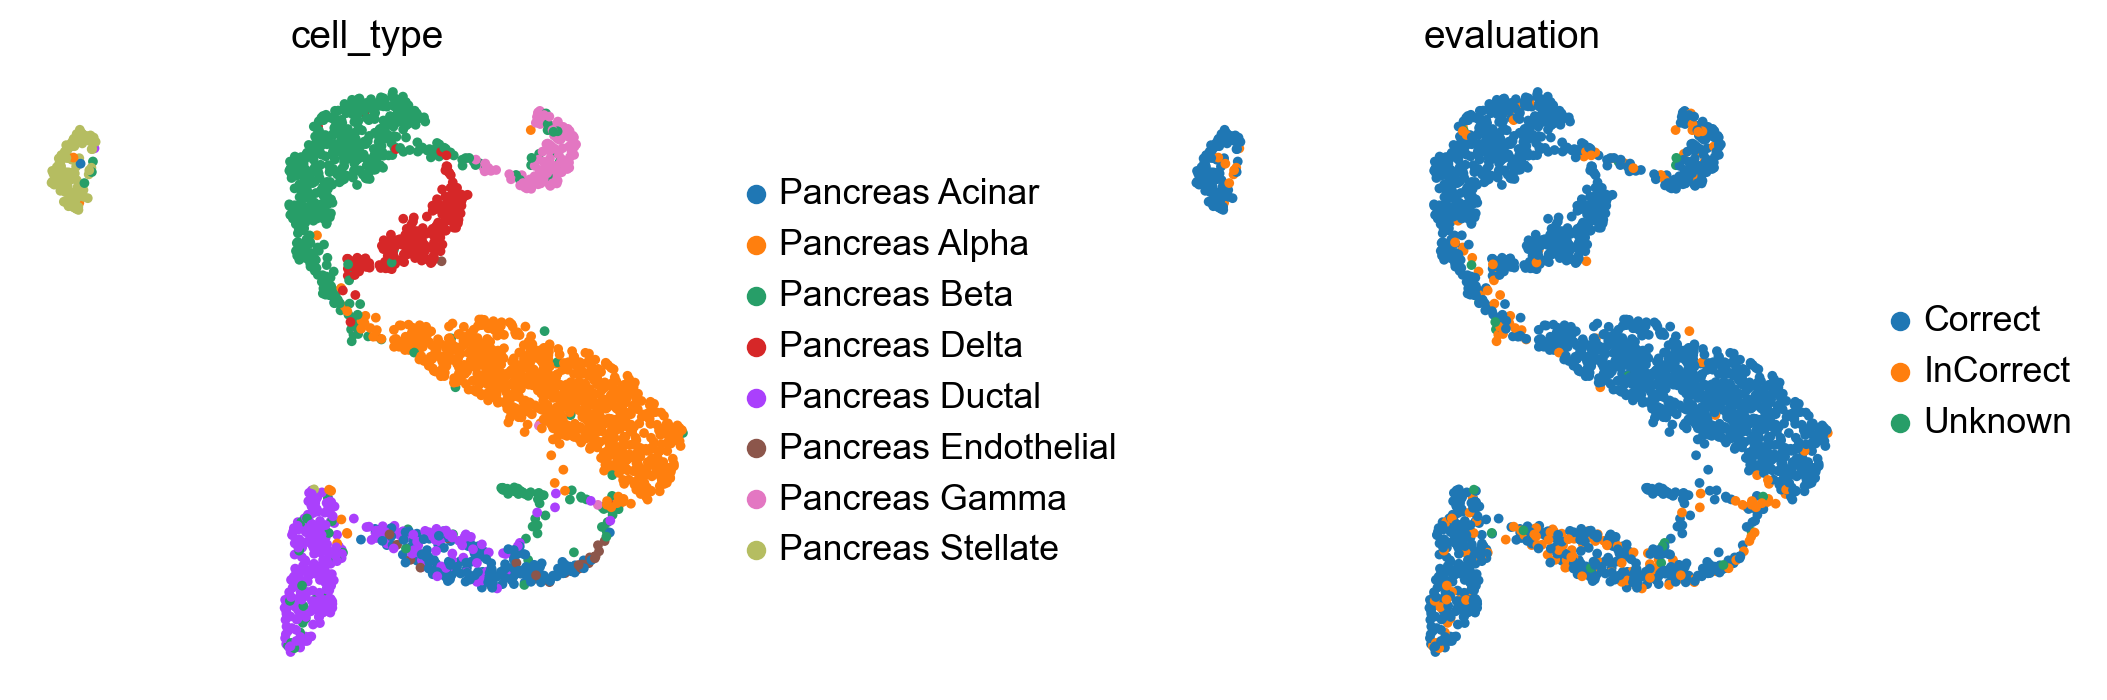

In [22]:
sc.pp.neighbors(valid_latent)
sc.tl.umap(valid_latent)
sc.pl.umap(valid_latent, color=["cell_type", 'evaluation'], wspace=0.5, frameon=False)

### Uncertainty UMAP visualization 

__Hint__ : higher the uncentainty shows the classifer was not confident about the predicted labels in that region

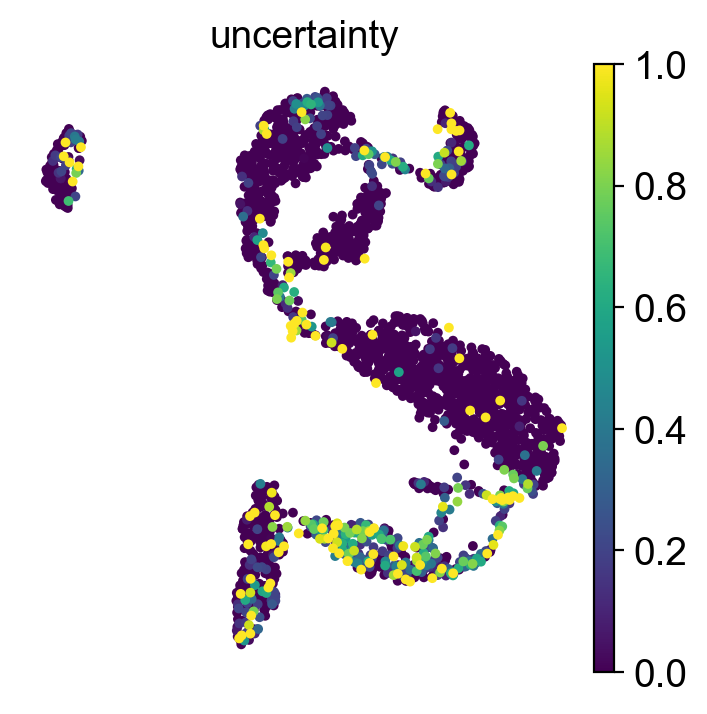

In [23]:
sc.pl.umap(valid_latent, color='uncertainty', frameon=False)